# Molecular Dynamics of A Lennard Jones Fluid #

This jupyter notebook loosely follows Chapter 4 of *Understanding Molecular Simulation: From Algorithms to Applications* by Daan Frenkel and Berend Smit:

Frenkel, D.; Smit, B. Chapter 4: Molecular Dynamics Simulations. In *Understanding Molecular Simulation: From Algorithms to Applications*; Computational Science Series, Vol. 1; Frenkel, D., Klein, M., Parrinello, M., Smit, B., Eds.; Academic Press, 2002; pp 63-107. ISBN 0-12-267351-4.

## Necessary Packages ##

In [2]:
import numpy as np # Arrays make the math so much faster
import matplotlib.pyplot as plt # For plotting
from matplotlib.ticker import FixedLocator, MaxNLocator, AutoMinorLocator # For setting locations of x and y ticks on plots
import matplotlib.animation as animation # For Lennard Jones Demo
from matplotlib.patches import Circle
from tqdm.notebook import tqdm # A very handy progress bar
from IPython.display import HTML
from numba import njit

## Parameters ##
Keep in mind that we will operate in reduced (i.e. dimensionless) units throughout this calculation. Here, we provide the parameters with their units and convert them into their reduced form. The output is going to need to be converted back to units with dimensions so that they will make sense. Operating in reduced units will allow us to greatly simplify the equations, making our code more scalable. While this may not be entirely necessary for the small systems we will simulate here, it is good practice as reduced units are commonplace in molecular dynamics.

Here are the conversions:
| Unit | Symbol | Reduced Form |
| --- | --- | --- |
| Length | $r^{*}$ | $r/\sigma$ |
| Time | $t^{*}$ | $t\sqrt{\frac{\epsilon}{m\sigma^2}}$ |
| Temperature | $T^{*}$ | $\frac{k_BT}{\epsilon}$ |
| Force | $F^{*}$ | $\frac{F\sigma}{\epsilon}$ |
| Energy | $U^{*}$ | $\frac{U}{\epsilon}$ |
| Pressure | $p^{*}$ | $\frac{p\sigma^3}{\epsilon}$ |
| Density | $\rho^{*}$ | $\rho\sigma^3$ |
| Surface Tension | $\gamma^{*}$ | $\frac{\gamma\sigma^2}{\epsilon}$ |

Typically, people perform the Lennard Jones simulation using liquid argon. You can of course do something different if you would like, but for your reference: $\sigma_{Ar}=3.405 \mathring A$, $\epsilon_{Ar}=0.238 \; \mathrm{kcal} \; \mathrm{mol^{-1}}$, and $m = 0.03994 \; \mathrm{kg} \; \mathrm{mol^{-1}}$. You also need to set a temperature and a density. A common temperature used for this simulation is $\mathrm{120 \; K}$ (in reduced units this is $\mathrm{\sim 1}$). At this temperature, the density of saturated liquid argon is $\mathrm{0.029027 \; mol \; cm^{-3}}$.

In [3]:
def handle_inputs(n_particles, temp, density, stepsizeA, stepsizeB, length_of_simulation, 
                  write_freq, sigma, epsilon, mass, file_namestem):
    '''
    Convert inputs to reduced units as necessary and make sure are correct

    Parameters
    ----------
    n_particles : int
        The number of particles
    temp : float
        The temperature in K
    density : float
        The density in mol/cm^3
    stepsizeA : float
        The smaller of the two stepsizes, will be selected 90% of the time. In Angstroms.
    stepsizeB  : float
        The larger of the two stepsizes, will be selected 10% of the time. In Angstroms.
    length_of_simulation : int
        The number of simulation steps to make
    write_freq : int
        The frequency to write to the output files in number of steps
    sigma : float
        The Lennard Jones sigma parameter in Angstroms
    epsilon : float
        The Lennard Jones epsilon parameter in kcal/mol
    mass : float
        The atomic mass in kg/mol
    file_namestem : str
        The namestem of the output files. e.g. if "LJFluid", files will be 
        named "LJFluid_positions.xyz", "LJFluid_energies.ene", etc. if 
        empty string ("") or None, files will be named "positions.xyz", 
        "energies.ene", etc.
    
    Returns
    -------
    time_step : float
        The time step in reduced units
    file_namestem : float
        The corrected namestem
    '''
    # Convert Temperature
    red_temp = temp * 0.001987204259 / epsilon # T* = T*(k_B/epsilon)

    # Convert stepsizes
    red_stepsizeA = stepsizeA / sigma 
    red_stepsizeB = stepsizeB / sigma 

    # Adjust Namestem
    if file_namestem != "" and file_namestem is not None and file_namestem[-1] != "_":
        file_namestem = file_namestem + "_"
    elif file_namestem is None:
        file_namestem = ""

    # Check validity of n_particles
    if (n_particles**(1/3))<int(n_particles**(1/3)):
        print(f"Error: You must be able to take the cubed root of n_particles evenly, but {n_particles}^(1/3)={n_particles**(1/3)}. Examples of valid choices are 8, 27, 216, etc.")
        del n_particles
    else:
        print(f"""            Input Parameters
            ----------------
            Number of Particles = {n_particles}
                    Temperature = {temp} K (T* = {red_temp})
                        Density = {density} mol/cm^3
                    Step Size A = {stepsizeA} Angstroms (stepsize* = {red_stepsizeA})
                    Step Size B = {stepsizeB} Angstroms (stepsize* = {red_stepsizeB})
           Length of Simulation = {length_of_simulation} steps 
              Writing Frequency = {write_freq} steps
                          Sigma = {sigma} Angstroms
                        Epsilon = {epsilon} kcal/mol
                           Mass = {mass} kg/mol

            Output Files
            ------------
            PBC-corrected positions: {file_namestem}positions.xyz
                      Raw positions: {file_namestem}unwrapped_positions.xyz
                           Energies: {file_namestem}energies.ene
        """)
    temp = red_temp 
    stepsizeA = red_stepsizeA
    stepsizeB = red_stepsizeB
    return stepsizeA, stepsizeB, file_namestem

## The Initialization ##
### Generate Initial Positions ###
There are many ways we could initialize the system. In this case (perhaps the simplest) we set the number of particles and density and use those parameters to determine the properly sized cubic box to fit them. You could also, however, choose the box size and density and fill the box with however many particles are needed. You could even make the box non-cubic, but that would complicate the treatment of periodic boundary conditions.

We can use the NumPy function, [`np.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), to easily place the particles on a cubic lattice.

In [4]:
def fill_box(n_particles, density, sigma):
    '''
    Create a box full of equally spaced atoms

    Parameters
    ----------
    n_particles : int
        The number of particles to place in the box
    density : float
        The density of the particles in the box
    sigma : float
        The lennard-jones sigma parameter
    Returns
    -------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The initial positions of the particles
    box_length : float
        The length of the box
    '''
    # Convert Density to Atoms/Angstrom^3
    density = density * 0.602214076 # Atoms/Angstrom^3 = mol/cm^3 * 6.02214076e23 1/mol * (1e-8 cm/Angstrom)^3

    # For a cubic box, there will be n_particles**(1/3) rows of particles in each dimension:
    positions_per_dim = int(np.round(n_particles ** (1/3)))
    
    # The box length will be (n_particles/density)**(1/3) [here we reuse positions_per_dim]:
    box_length = (positions_per_dim / (density ** (1/3)))/sigma
    
    # Find equally spaced positions for the particles along each dimesion:
    dim_positions, spacing = np.linspace(0, box_length, positions_per_dim, endpoint=False, retstep=True)
    dim_positions = dim_positions + spacing/2 # Center in box
    
    # Create a 3D grid using those positions and then collapse it into a (n_particles, 3) shaped array:
    X, Y, Z = np.meshgrid(dim_positions, dim_positions, dim_positions)
    positions = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

    return positions, box_length

## The Potential Calculation ##

### The Lennard-Jones Potential ###

The Lennard-Jones potential is perhaps the most famous intermolecular pair potential, given by:

$V_{LJ}(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]$

Which, when expressed using reduced units is:

$V_{LJ}^*(r^*) = 4\left[ \left( \frac{1}{r^*} \right)^{12} - \left( \frac{1}{r^*} \right)^{6} \right]$

### Using a Potential Cutoff ###

In practice, when using periodic boundary conditions, we need to provide some distance cutoff ```rcut``` so that the calculation does not get too expensive, and importantly, so that a force between two atoms only has to be accounted for once. We also then need to shift the energies with ```ecut```. A typical value for ```rcut``` is $2.5\sigma$, however, ```rcut``` must be $\leq$ ```box_length```/2. ```ecut``` can be calculated from ```rcut``` with the following equation:

$\texttt{ecut} = 4 \left(\frac{1}{\texttt{rcut}^{12}}-\frac{1}{\texttt{rcut}^6} \right)$

These values will always be the same, so we can create the following function to calculate them before we begin the simulation.

In [5]:
def get_cutparams(box_length):
    '''
    calculate values for the cutoffs used in the force calculation.
    Parameters
    ----------
    box_length : Float
        The length of the box
    
    Returns
    -------
    rcut2 : Float
        The cutoff distance squared
    ecut : Float
        The energy shift
    '''
    # get rcut
    rcut = 2.5
    if rcut > box_length/2:
        rcut = box_length/2
        print(f"Warning: Your system is likely too small and so you will likely witness artifacts as rcut ({rcut}) is set to less than 2.5*sigma.")

    # get rcut2
    rcut2 = rcut**2

    # get ecut
    rcuti6 = 1/(rcut**6) # Precalc inverse of rcut^6
    ecut = 4 * rcuti6 * (rcuti6 - 1) # Energy cutoff

    return rcut2, ecut


Below, lies a function that can be used to compute the Lennard-Jones potentials between each pair of particles in a cubic periodic box given an array of the particles' coordinates and the length of a side of the box. This is the function that makes the simulation so computationally expensive. We can make up for some of this using the [numba](https://numba.readthedocs.io/en/stable/user/5minguide.html) package's `@njit` decorator.

In [6]:
@njit
def setup_potential_energies(positions, box_length, rcut2, ecut):
    '''
    Calculate the potential energies for ALL pairs of particles

    Parameters
    ----------
    positions : numpy.ndarray(dtype=np.float64, shape=(N_particles, 3))
        The current positions of the particles
    box_length : np.float64
        The length of the box
    rcut2 : np.float64
        The distance cutoff
    ecut : np.float64
        The energy shift

    Returns
    -------
    potential_energies : np.ndarray(shape=(N_particles, N_particles))
        The potential energies for each pair of particles
    '''
    potential_energies = np.zeros((positions.shape[0], positions.shape[0]))
    # Loop through all pairs of atoms
    for i in range(positions.shape[0]-1): 
        for j in range(i+1, positions.shape[0]):
            r = positions[i]-positions[j] # distance vector
            r = r - (box_length*np.round(r/box_length)) # Periodic boundary conditions
            r2 = np.sum(r**2)

            if r2 < rcut2: # If within cutoff distance
                # Calculate force between particles
                r2i = 1/r2
                r6i = r2i**3
                # Add potential energy of interaction to total potential energy 
                pe = ((4*r6i*(r6i-1)) - ecut)/2 # 2*r6i*(r6i-1) # 
                potential_energies[i, j] = pe
                potential_energies[j, i] = pe

    return potential_energies

@njit
def updated_potential_energies(potential_energies, i, positions, box_length, rcut2, ecut):
    '''
    Update the potential_energies array to reflect a new position for a single particle

    Parameters
    ----------
    potential_energies : np.ndarray(shape=(N_particles, N_particles))
        The potential energies for each pair of particles
    i : int 
        The index of the particle that has a new position
    positions : numpy.ndarray(dtype=np.float64, shape=(N_particles, 3))
        The current positions of the particles
    box_length : np.float64
        The length of the box
    rcut2 : np.float64
        The distance cutoff
    ecut : np.float64
        The energy shift

    Returns
    -------
    potential_energies : np.ndarray(shape=(N_particles, N_particles))
        The updated potential energies for each pair of particles
    '''
    rvals = positions-positions[i]
    rvals = rvals - (box_length*np.round(rvals/box_length))
    r2vals = np.sum(rvals**2, axis=1)
    r2ivals = 1/r2vals
    r6ivals = r2ivals**3
    pevals = ((4*r6ivals*(r6ivals-1)) - ecut)/2 #2*r6ivals*(r6ivals-1)
    pevals[r2vals>=rcut2] = 0
    pevals[i] = 0
    potential_energies[:, i] = pevals
    potential_energies[i, :] = pevals

    return potential_energies

## Metropolis Monte Carlo ##

In [7]:
def metropolis_step(positions, potential_energies, n_accepted, i, shift, accrandom, box_length, rcut2, ecut, T, epsilon):
    '''
    Perform an integration step using the Velocity Verlet algorithm

    Parameters
    ----------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current positions of the particles before the step
    potential_energies : np.ndarray(shape=(N_particles, N_particles))
        The potential energies for each pair of particles before the step
    n_accepted : int
        The number of accepted moves that have been made before the step
    i : int
        The index of the particle that will be moved in this step (should be randomly generated)
    shift : np.ndarray(dtype=float, shape=(3,))
        A vector with the distance along each dimension to move the particle (should be randomly generated)
    accrandom : float
        A random number between 0 and 1 for comparison to the acceptance probability 
    box_length : np.float64
        The length of the box
    rcut2 : np.float64
        The distance cutoff
    ecut : np.float64
        The energy shift
    T : float
        The temperature (in K) the simulation is being run at
    epsilon : float
        The lennard-jones epsilon parameter
    Returns
    -------
    positions : numpy.ndarray(dtype=float, shape=(N_particles, 3))
        The current positions of the particles after the step
    potential_energies : np.ndarray(shape=(N_particles, N_particles))
        The potential energies for each pair of particles after the step
    n_accepted : int
        The number of accepted moves that have been made after the step
    '''
    # Get the updated positions and potential energies
    new_positions = positions.copy()
    new_positions[i] = new_positions[i] + shift
    new_potential_energies =  updated_potential_energies(potential_energies.copy(), i, new_positions, box_length, rcut2, ecut)

    # The Metropolis Condition
    exponent = (-np.sum(new_potential_energies)+np.sum(potential_energies))*epsilon/(0.001987204259*T) 
    if np.exp(exponent) <= accrandom: # If the ratios of new prob to old prob is less than the random number 
        return positions, potential_energies, n_accepted # Reject the update
    else: # Otherwise 
        n_accepted += 1
        return new_positions, new_potential_energies, n_accepted # Accept the update

## Write the positions and energies ##
Keep in mind that we are performing the calculations in reduced units, so if we want our output to be meaningful we need to reintroduce dimensionality.

**This class writes the results in the following units:**
| Type | Units |
| ---- | ----- |
| Positions | Å |
| Velocities | Å/ps |
| Temperatures | $K$ |
| Forces | kcal/(mol Å) |
| Energies | kcal/mol |
| Times | ps |

Using a class like this can be handy. This way, you can keep the files open while the dynamics runs rather than repeatedly closing and reopening it; HOWEVER; IT IS CRITICAL YOU REMEMBER TO CLOSE THE FILES WITH ```OutputWriter.finish()```!!!

In [8]:
class OutputWriter:
    '''
    A class for writing positions and energies

    Methods
    -------
    write_energies(time, total_energy, kinetic_energy, potential_energy, current_temperature)
        Writes energies to a .ene file
    write_positions(time, positions=None, velocities=None, forces=None)
        Writes positions to .xyz files
    finish()
        Closes files

    '''
    def __init__(self, sigma, epsilon, box_length, file_namestem):
        ''' 
        Parameters
        ----------
        sigma : Float
            The sigma parameter
        epsilon : Float
            The epsilon parameter
        mass : Float
            Mass in kg/mol
        box_length : Float
            The length of one box side
        file_namestem
        '''
        self.__energy_file = open(f"{file_namestem}energies.ene", "w")
        self.__positions_file = open(f"{file_namestem}positions.xyz", "w")
        self.__unwrapped_positions_file = open(f"{file_namestem}unwrapped_positions.xyz", "w")
        self.__sigma = sigma
        self.__epsilon = epsilon
        self.__box_length = box_length*sigma

        # Also put header on energy file
        self.__energy_file.write(f'# TIMESTEP EQ/PROD(0/1) TOTAL_ENE KINETIC_ENE POTENTIAL_ENE TEMP\n')

        # Also, precalculate some conversion factors
        self.__enecf = self.__epsilon

    
    def write_energy(self, time, potential_energies):
        '''
        Write to the energy file

        Parameters
        ----------
        time : float
            The current time
        total_energy : float
            The total energy
        kinetic_energy : float
            The kinetic energy
        potential_energy : float
            The potential energy
        current_temperature : float
            The temperature
        production : bool
            If this is a production step. False for an equilibration step
        '''
        # Need to correct this so you aren't writing reduced units
        self.__energy_file.write(f'{time}    {np.sum(potential_energies)*self.__enecf}\n')

    def write_positions(self, step, positions):
        '''
        Write the positions

        Parameters
        ----------
        time : float
            The current time
        positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
            The current positions of the particles.
        production : bool
            If this is a production step. False for an equilibration step
        '''
        def _format_posline(x, y, z):
            return f"Ar {x:>8.3f}{y:>8.3f}{z:>8.3f}\n"
        #--------------------------------------------
        
        # convert positions into angstroms
        positions = positions * self.__sigma
        # Save raw (unwrapped) positions
        self.__unwrapped_positions_file.write(f'{positions.shape[0]}\nTS {step} steps (1)\n')
        for i in positions:
            self.__unwrapped_positions_file.write(_format_posline(i[0], i[1], i[2]))

        # Save wrapped positions (PBC applied)
        self.__positions_file.write(f'{positions.shape[0]}\nTS {step} steps (1)\n')
        for i in positions:
            self.__positions_file.write(_format_posline(i[0] - (self.__box_length * np.round(i[0]/self.__box_length)),
                                                        i[1] - (self.__box_length * np.round(i[1]/self.__box_length)),
                                                        i[2] - (self.__box_length * np.round(i[2]/self.__box_length))))

    def finish(self, energies=True, positions=True, unwrapped_positions=True, velocities=True, forces=True):
        '''
        Close the files (important)

        Parameters
        ----------
        energies : Bool
            Whether to close the energies file
        positions : Bool
            Whether to close the position file
        unwrapped_positions : Bool
            Whether to close the unwrapped position file
        velocities : Bool
            Whether to close the velocities file
        forces : Bool
            Whether to close the forces file
        '''
        if energies:
            self.__energy_file.close()
        if positions:
            self.__positions_file.close()
        if unwrapped_positions:
            self.__unwrapped_positions_file.close()

We'll also need a function to read an xyz file (the files containing the positions, velocities, and forces).

In [9]:
def readXYZ(filename, stage="both"):
    '''
    Reads an XYZ file (that was written by OutputWriter)

    Parameters
    ----------
    filename : str
        Name of the file to read
    stage : "equilibration", "production", "both"
        Which stage of the simulation to read. Default is "both". This doesn't do anything in this code

    Returns
    -------
    times : numpy.ndarray(shape=(N_frames,))
        The times at each timestep (in ps)
    frames : numpy.ndarray(shape=(N_frames, N_atoms, 3))
        The data stored in the file for each frame
    '''
    def _floatcheck(str):
        # Check if string is a float
        return str.replace(".", "").replace("-", "").isnumeric()
    
    with open(filename, "r") as file:
        new_frame = True
        frames, times = [], []
        for i, line in enumerate(file.readlines()):
            lc = line.strip().split() # The line contents as a list without leading and trailing whitespace
            if len(lc) == 1 and lc[0].isnumeric():
                natoms = int(lc[0])
                new_frame = True
            elif len(lc) == 4 and _floatcheck(lc[1]) and new_frame:
                if (stage=="both" or (stage=="equilibration" and lc[3]=="(0)") or (stage=="production" and lc[3]=="(1)")): # Check if this line has the time and is in the right stage
                    frames.append(np.zeros((natoms, 3))) # Create empty array to hold this frames positions
                    curr_atom = 0
                    times.append(float(lc[1]))
                    new_frame = False
                else:
                    continue
            elif len(lc) == 4 and _floatcheck(lc[1]) and _floatcheck(lc[2]) and _floatcheck(lc[3]):
                if not new_frame:
                    frames[-1][curr_atom, :] = list(map(float, lc[1:]))
                    curr_atom += 1
            else:
                print(f"Error: Unrecognized line ({i}) of {filename}: {line}")
                break
    return np.array(times), np.array(frames)

## Putting it all together ##

In [10]:
def run(n_particles=216, temp=120.0, density=0.0291, stepsizeA=0.01, stepsizeB=0.1, length_of_simulation=10000, write_freq=10, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file=None, file_namestem=None):
    '''
    Convert inputs to reduced units as necessary and make sure are correct

    Parameters
    ----------
    n_particles : int
        The number of particles. Default is 216
    temp : float
        The temperature in K. Default is 120.0
    density : float
        The density in mol/cm^3. Default is 0.0291
    stepsizeA : float
        The smaller of the two stepsizes, will be selected 90% of the time. In Angstroms.
    stepsizeB  : float
        The larger of the two stepsizes, will be selected 10% of the time. In Angstroms.
    length_of_simulation : int
        The number of simulation steps to make. Default is 10000
    write_freq : int
        The frequency to write to the output files in number of steps. 
        Default is 10
    sigma : float
        The Lennard Jones sigma parameter in Angstroms. Default is 3.405
    epsilon : float
        The Lennard Jones epsilon parameter in kcal/mol. Default is 0.238
    mass : float
        The atomic mass in kg/mol. Default is 0.03994
    file_namestem : str
        The namestem of the output files. e.g. if "LJFluid", files will be 
        named "LJFluid_positions.xyz", "LJFluid_energies.ene", etc. if 
        empty string ("") or None, files will be named "positions.xyz", 
        "energies.ene", etc. Default is None
    '''
    # INITIALIZATION (Fill the box, generate initial velocities, and determine positions at t=-1)
    stepsizeA, stepsizeB, file_namestem = handle_inputs(n_particles, temp, density, stepsizeA, stepsizeB, length_of_simulation, write_freq, sigma, epsilon, mass, file_namestem)

    # Initialize system
    positions, box_length = fill_box(n_particles, density, sigma)
    print(f"Box Length: {box_length*sigma:.3f} Angstroms")
    
    if starting_positions_file is not None:
        positions = np.loadtxt(starting_positions_file, dtype=float)/sigma

    # Get cutoff parameters
    rcut2, ecut = get_cutparams(box_length)

    # Calculate initial potential energies
    potential_energies = setup_potential_energies(positions, box_length, rcut2, ecut)
    
    # Initialize writer and write initial conditions
    w = OutputWriter(sigma, epsilon, box_length, file_namestem)
    w.write_energy(0, potential_energies)
    w.write_positions(0, positions)
    
    # Precompute all needed random numbers
    rng = np.random.default_rng()
    rand_stepsize = rng.uniform(0, 1, length_of_simulation)
    stepsizes = np.full(length_of_simulation, stepsizeA)
    stepsizes[rand_stepsize<=0.1] = stepsizeB
    randomshifts = rng.uniform(-0.5, 0.5, size=(length_of_simulation, 3))*stepsizes[:, np.newaxis]
    accrandom = rng.uniform(0, 1, size=length_of_simulation)
    atomselections = rng.integers(0, positions.shape[0], size=length_of_simulation)

    # THE SIMULATION
    n_accepted = 0
    for step in tqdm(range(1, length_of_simulation+1)):
        positions, potential_energies, n_accepted = metropolis_step(positions, potential_energies, n_accepted, atomselections[step-1], randomshifts[step-1], accrandom[step-1], box_length, rcut2, ecut, temp, epsilon)
        
        if step % write_freq == 0:
            w.write_positions(step, positions)
            w.write_energy(step, potential_energies)
        
    w.finish()

    print(f"Acceptance Probability: {n_accepted/length_of_simulation}")

In [13]:
# run(n_particles=216, temp=120, density=0.0291, stepsizeA=0.4, stepsizeB=0.8, length_of_simulation=2160000, write_freq=216, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file="starting_positions.dat", file_namestem="liquid")

# run(n_particles=216, temp=120, density=0.0291, stepsizeA=0.6, stepsizeB=1.2, length_of_simulation=2160000, write_freq=216, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file="starting_positions.dat", file_namestem="liquid")

run(n_particles=216, temp=120, density=0.0291, stepsizeA=0.8, stepsizeB=1.6, length_of_simulation=2160000, write_freq=216, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file="starting_positions.dat", file_namestem="")

# run(n_particles=216, temp=120, density=0.0291, stepsizeA=1.0, stepsizeB=2.0, length_of_simulation=2160000, write_freq=216, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file="starting_positions.dat", file_namestem="liquid")

# run(n_particles=216, temp=120, density=0.0291, stepsizeA=1.2, stepsizeB=2.4, length_of_simulation=2160000, write_freq=216, sigma=3.405, epsilon=0.238, mass=0.03994, starting_positions_file="starting_positions.dat", file_namestem="liquid")

            Input Parameters
            ----------------
            Number of Particles = 216
                    Temperature = 120 K (T* = 1.0019517272268907)
                        Density = 0.0291 mol/cm^3
                    Step Size A = 0.8 Angstroms (stepsize* = 0.23494860499265788)
                    Step Size B = 1.6 Angstroms (stepsize* = 0.46989720998531576)
           Length of Simulation = 2160000 steps 
              Writing Frequency = 216 steps
                          Sigma = 3.405 Angstroms
                        Epsilon = 0.238 kcal/mol
                           Mass = 0.03994 kg/mol

            Output Files
            ------------
            PBC-corrected positions: positions.xyz
                      Raw positions: unwrapped_positions.xyz
                           Energies: energies.ene
        
Box Length: 23.100 Angstroms


  0%|          | 0/2160000 [00:00<?, ?it/s]

Acceptance Probability: 0.4949125


## Analysis ##

### Check the energies ###
If we did everything correctly, we should see the energies (and temperature) converge to an equilibrium and fluctuate around it.

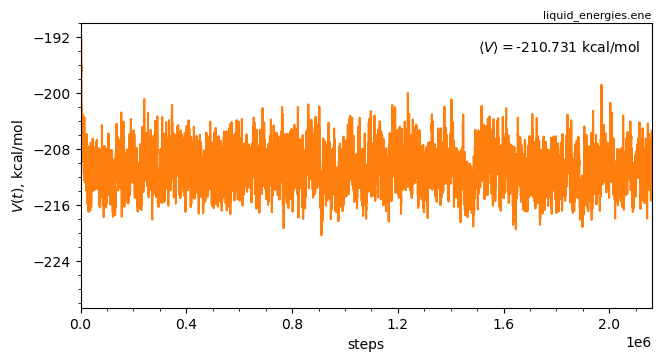

In [25]:
def plot_energies(file_namestem):
    energy_data = np.loadtxt(f'liquid_energies.ene')
    fig, ax = plt.subplots(figsize=(6.5, 3.5), constrained_layout=True, gridspec_kw={'hspace':0.08})
    
    # Potential Energy
    ax.plot(energy_data[:,0], energy_data[:,1], color='tab:orange')
    ax.annotate(r'$\langle V \rangle = $'+f'{np.mean(energy_data[1000:,1]):.3f} kcal/mol', (0.98,0.9), xycoords='axes fraction', ha='right')
    
    ax.set_ylabel(r'$V(t)$'+', kcal/mol')
    ax.set_xlabel("steps")
    ax.set_xlim(0, energy_data[:,0].max())
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_title(f'{file_namestem}energies.ene', loc="right", pad=4, fontsize=8)
    plt.show()
plot_energies("liquid_")

### The Radial Distribution Function, $g(r)$ ###

The radial distribution function, $g(r)$, describes the structure of the system. To calculate $g(r)$ for a given particle you count the number of particles between $r$ and $r+dr$ away, $N_{r}$. Then, you calculate $g(r)$:

$$ g(r) = \frac{N_r}{\rho 4 \pi r^2 dr}. $$

In practice, this looks like creating a histogram around each particle and then averaging the particles' histogram bins.

In [26]:
@njit
def rdf(trajectory, box_length, nbins):
    '''
    Compute the radial distribution function

    Parameters
    ----------
    trajectory : numpy.ndarray(shape=(n_frames, n_particles, 3), dtype=float)
        The trajectory of unwrapped positions of the particles through the trajectory.
    box_length : float
        The length of the box, in angstroms.
    nbins : int
        The number of RDF bins

    Returns
    -------
    r_values : numpy.ndarray(ndim=1, size=box_length/(2*dr), dtype=float)
        The values of r corresponding to the values in g_r
    gr_values : numpy.ndarray(ndim=1, size=box_length/(2*dr), dtype=float)
        The radial distribution function
    '''
    rho = trajectory[0].shape[0]/(box_length**3) # number density of system
    dr = box_length/(2*nbins)
    r_values = np.arange(0, box_length/2, dr)[:-1]
    gr_values = np.zeros_like(r_values)
    for unwrapped_positions in trajectory:
        for i in range(unwrapped_positions.shape[0]-1):
            for j in range(i+1, unwrapped_positions.shape[0]):
                r = unwrapped_positions[i]-unwrapped_positions[j]
                r = r - (box_length*np.round(r/box_length)) # Periodic boundary conditions
                r = np.sqrt(np.sum(r**2)) # distance
                if r < box_length/2: # If less than max radius
                    ri = int(np.floor(r/dr)) # bin index
                    gr_values[ri] += 2
    
    
    vol = (4/3)*np.pi*((r_values+dr)**3-r_values**3) # volume between r and r+dr for each r
    nid = vol*rho # for case of ideal distribution of atoms
    gr_values = gr_values / (nid*trajectory.shape[0]*trajectory.shape[1])

    r_values = r_values + (dr/2)

    return r_values, gr_values

In [28]:
times, trajectory = readXYZ(f"liquid_unwrapped_positions.xyz", stage="production")
r, gr = rdf(trajectory, 23.1, 1000)

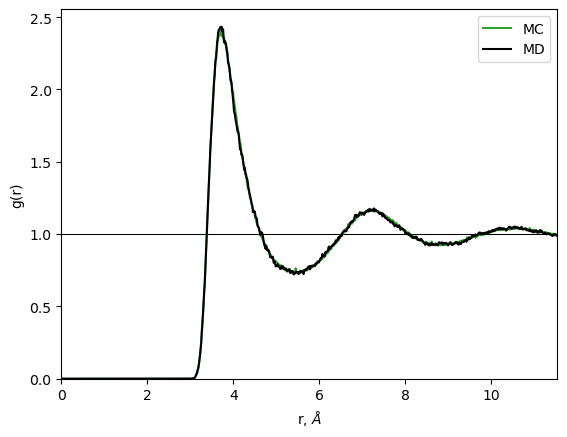

In [30]:
grMD = np.loadtxt("MD_rdf.dat", dtype=float)

fig, ax = plt.subplots()
ax.axhline(1, color="k", linewidth=0.75)
ax.plot(r, gr, color="tab:green", label="MC")
ax.plot(grMD[:,0], grMD[:,1], color="k", label="MD")
ax.set_ylim(0,np.max([gr.max(), grMD[:,1].max()])*1.05)
ax.set_xlim(0,np.max(r))
ax.set_xlabel(f"r, $\AA$")
ax.set_ylabel("g(r)")
ax.legend()
plt.show()